In [2]:
from lstmvae import VAE
import numpy as np
import torch
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from torch.utils.data import DataLoader, TensorDataset

In [3]:
f=loadmat('../data/ant_dataset_gt.mat')
track=f['traj_gt']
print("track shape",track.shape)
t=track.transpose(1,0,2)
t=t.reshape(10399,-1)
print('t shape',t.shape)


track shape (20, 10399, 2)
t shape (10399, 40)


In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
t_scaled = scaler.fit_transform(t)
print(t_scaled.shape)

(10399, 40)


In [5]:
train=t_scaled[:1000]
train=np.expand_dims(train,1)
# train

In [6]:
# train=t1
sequence_length = train.shape[1]
number_of_features = train.shape[2]
print(sequence_length,number_of_features,train.shape,'seqlen, no_feature, shape')
 
train_dataset = TensorDataset(torch.from_numpy(train.copy()))
test=train[1]
test=np.expand_dims(test,0)
print(test.shape)
test_dataset = TensorDataset(torch.from_numpy(test))

1 40 (1000, 1, 40) seqlen, no_feature, shape
(1, 1, 40)


In [7]:
hidden_size = 32
hidden_layer_depth = 2
latent_length = 1
batch_size = 1
learning_rate = 0.0005
# n_epochs = 150
n_epochs = 2
dropout = 0
cuda = True 
print_every=500
clip = True 
max_grad_norm=3
loss = 'MSELoss' 
vrae = VAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = 0,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm)
print(vrae)

using CUDA
VAE(
  (encoder): Encoder(
    (model): LSTM(40, 32, num_layers=2)
  )
  (lmbd): Lambda(
    (hidden_to_mean): Linear(in_features=32, out_features=1, bias=True)
    (hidden_to_logvar): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Decoder(
    (model): LSTM(1, 32, num_layers=2)
    (latent_to_hidden): Linear(in_features=1, out_features=32, bias=True)
    (hidden_to_output): Linear(in_features=32, out_features=40, bias=True)
  )
  (loss_fn): MSELoss()
)


/home/amir/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [9]:
# vrae.trainer(train_dataset)
vrae.load('../saved_model/ant_z_1000.pth')

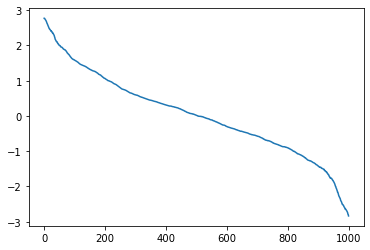

In [10]:
k=vrae.reconstruct(train_dataset)
z=vrae.transform(train_dataset)
plt.plot(z)

In [11]:
print(train.squeeze().shape)
train=train.squeeze()
print(k.squeeze().shape)
k=k.squeeze()

(1000, 40)
(1000, 40)


In [12]:
def plot_traj(num,ax,x):
    ax.scatter(train[:,num],train[:,num+1],label="Observed")
    ax.plot(k[:,num],k[:,num+1],label="Reconstructed",color='r')
    ax.set_title('Ant:'+str(x),fontsize=40)
    plt.xlim(0,1)
    plt.ylim(0,1)
    ax.legend(fontsize=25,loc='lower left',fancybox=True)

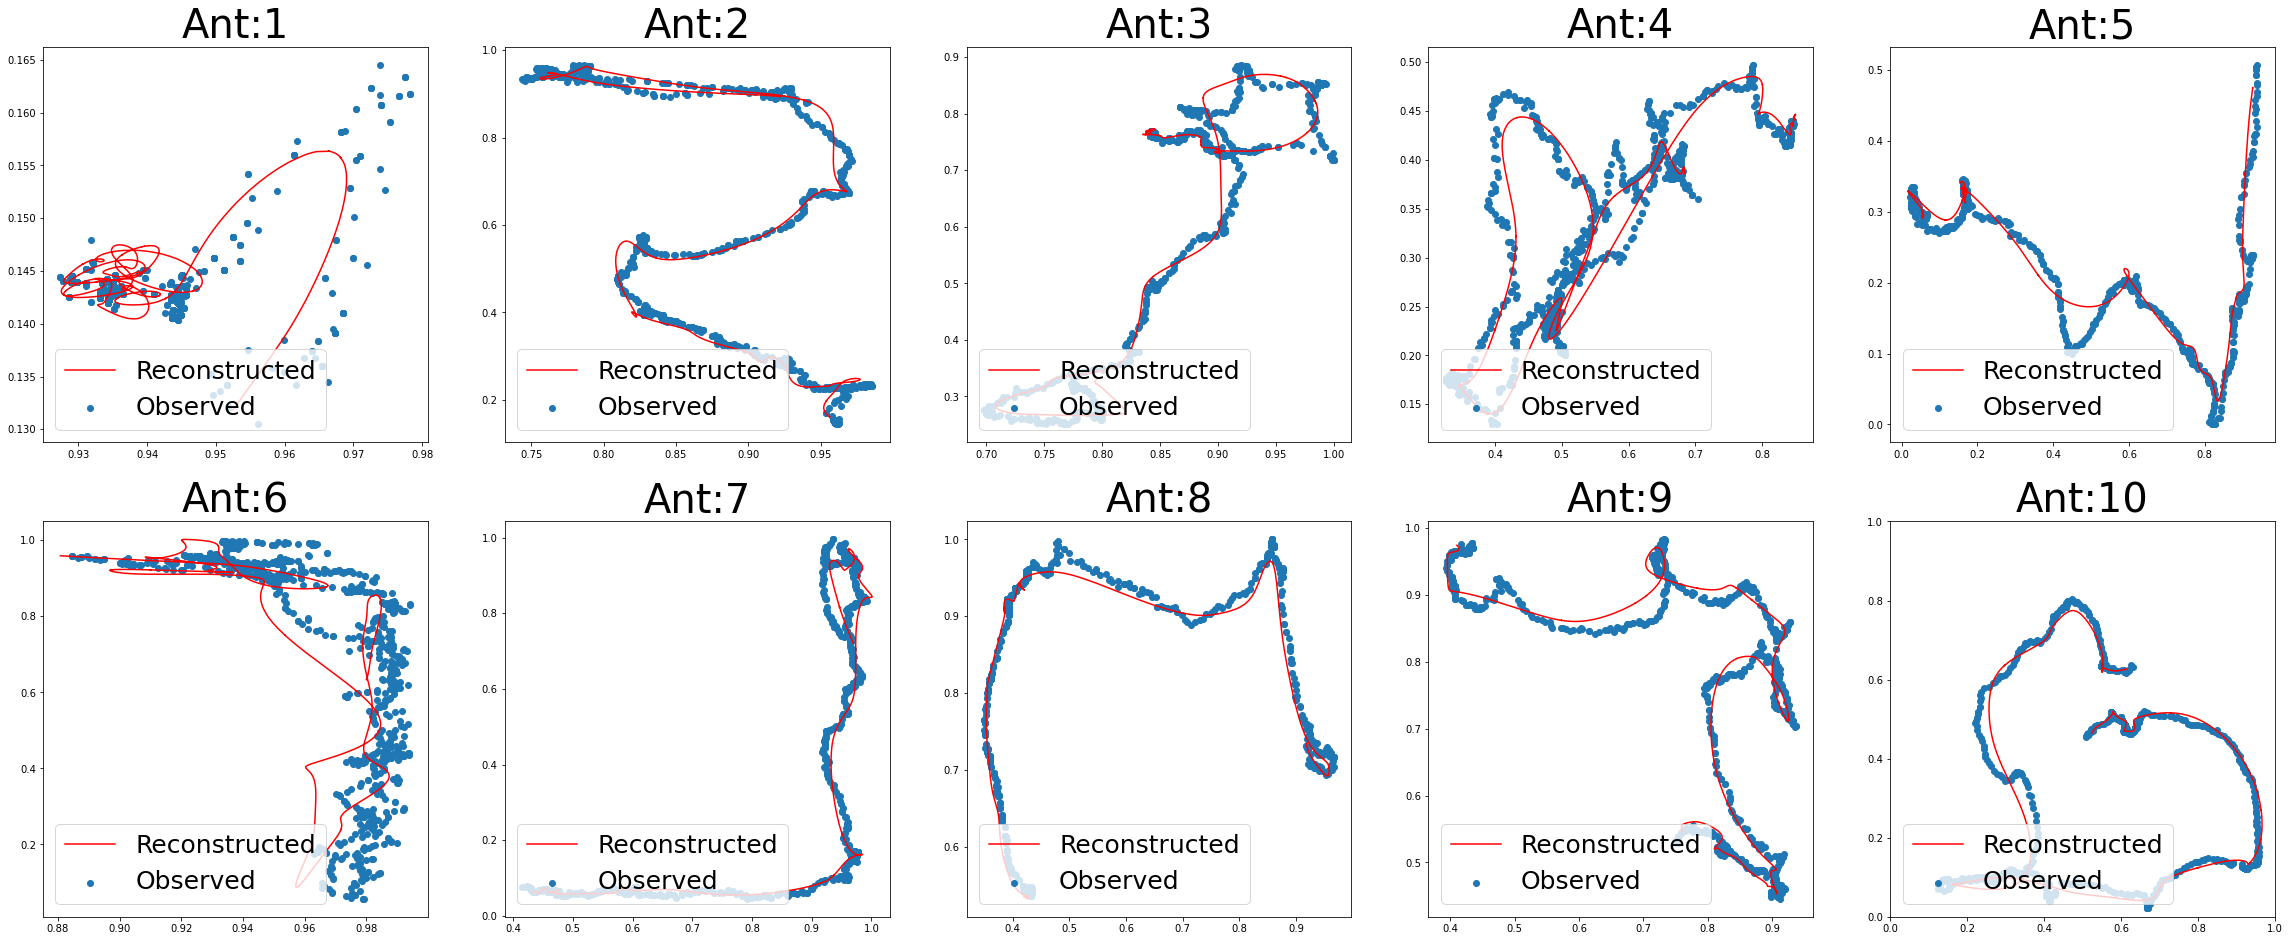

In [13]:
fig, axs = plt.subplots(2, 5,figsize=(40,16))
num=0
plot_traj(0,axs[0,0],1)
plot_traj(2,axs[0,1],2)
plot_traj(4,axs[0,2],3)
plot_traj(6,axs[0,3],4)
plot_traj(8,axs[0,4],5)
plot_traj(10,axs[1,0],6)
plot_traj(12,axs[1,1],7)
plot_traj(14,axs[1,2],8)
plot_traj(16,axs[1,3],9)
plot_traj(18,axs[1,4],10)

In [14]:
# fig.savefig('./Paper stuff/recon_ant500.png', dpi=400,bbox_inches='tight')

In [15]:
import numpy as np
import pysindy as ps
from scipy.signal import savgol_filter

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x'],
      optimizer=STLSQ(threshold=0.001))

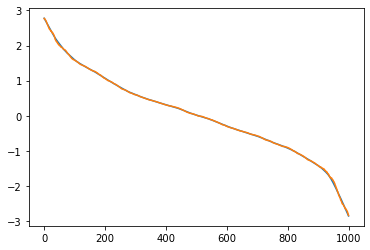

In [16]:
f_f=savgol_filter(z,51,1,axis=0)
plt.plot(f_f)
plt.plot(z)

feature_library = ps.PolynomialLibrary(degree=2)

optimizer = ps.STLSQ(threshold=0.001)

model = ps.SINDy(optimizer=optimizer,feature_library=feature_library,feature_names=["x"])
t1=np.linspace(0, 1, 1000)

model.fit(f_f, t=t1)

In [17]:
model.print()
model.coefficients()
c=model.coefficients().squeeze()
model.score(f_f, t=t1)

x' = -2.479 1 + 0.541 x + -2.336 x^2


0.9254909949134364